**Import and setup path**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
data_dir = 'data/'
filepath = data_dir + 'AirPassengers.csv'
DATE_COL, VAL_COL = 'Month', '#Passengers'
filepath

'data/AirPassengers.csv'

# Data Setup

## Loading data

<AxesSubplot:>

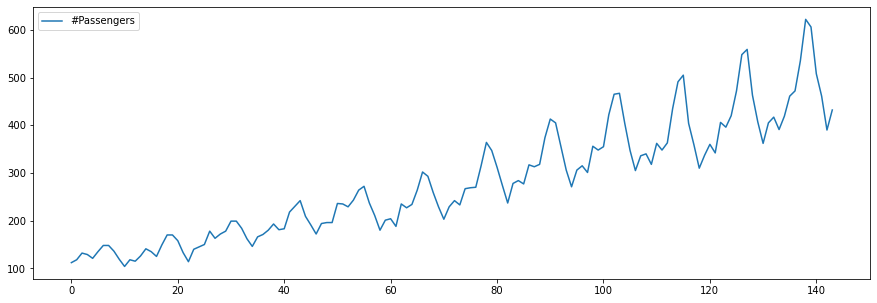

In [4]:
df_master = pd.read_csv(filepath)
df_master.plot()

## Explore data

In [5]:
df_master.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
df = df_master.copy()
df.Month = pd.to_datetime(df.Month, format='%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


## Set index

In [8]:
df = df.set_index(DATE_COL)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

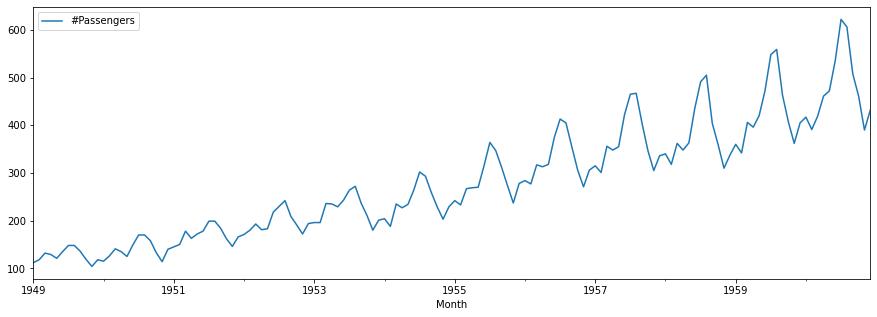

In [9]:
df.plot()

## Stationarity

- **Check stationarity and make the data be time series stationarity**

In [10]:
from statsmodels.tsa.stattools import adfuller


def adf_test(dataframe) -> None:
    adf, pvalue, _, _, critical_values, _ = adfuller(dataframe)
    is_stationary = pvalue <= 0.05
    test_stat_p_value = round(critical_values['5%'], 2)
    pvalue = round(pvalue, 2)
    adf = round(adf, 2)
    print(
        f'Is the time series stationary? {is_stationary}\n'
        f'test statistic value = {adf}\n'
        f'p value = {pvalue}\n'
        f'test critical values (5%) = {test_stat_p_value}' 
    )
    

adf_test(df)

Is the time series stationary? False
test statistic value = 0.82
p value = 0.99
test critical values (5%) = -2.88


- **Use the method from previous practical work to make data be stationarity quickly**

Is the time series stationary? True
test statistic value = -2.96
p value = 0.04
test critical values (5%) = -2.88


<AxesSubplot:xlabel='Month'>

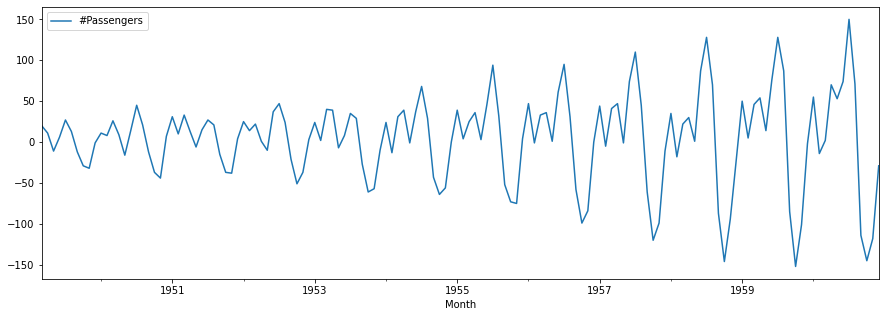

In [11]:
df = df.diff(2).dropna()
adf_test(df)
df.plot()

# Train an AR model

## Determine if the process is AR or not

In [12]:
from statsmodels.tsa.stattools import acf, pacf

In [13]:
acf(df)

array([ 1.        ,  0.5822477 , -0.04337616, -0.32649986, -0.34916999,
       -0.22472315, -0.14602314, -0.22133413, -0.34085469, -0.3076065 ,
       -0.04541068,  0.4987363 ,  0.85264827,  0.49830279, -0.04744865,
       -0.28572334, -0.27897604, -0.17052404, -0.12160365, -0.21622026,
       -0.3269304 , -0.27603482, -0.03215536,  0.43467687,  0.73320668,
        0.43248439, -0.04290421, -0.24142857, -0.22748344, -0.14270232,
       -0.10064918, -0.17886354, -0.27993761, -0.23606892, -0.02286963,
        0.35782924,  0.60935298,  0.36471169, -0.03202462, -0.17730936,
       -0.15901597])

In [14]:
pacf(df)

array([ 1.00000000e+00,  5.86377120e-01, -5.91064435e-01,  1.26688033e-01,
       -3.06181423e-01,  8.61697511e-02, -3.83786363e-01, -2.37968433e-01,
       -5.13661962e-01, -3.57845252e-01, -5.43448019e-01,  8.67139603e-01,
       -8.75260297e-01,  4.14738159e+00,  1.36762873e+00, -5.32685106e-01,
        4.71914420e-01, -3.70865069e-01,  9.58841171e-02, -4.49190596e-01,
        4.36039730e-01, -5.80684225e-01,  1.20473599e+00,  6.51665632e+00,
       -8.96404570e-01,  4.75263885e-01, -3.27404861e-01,  2.89169356e-01,
       -6.60449599e-01,  4.24110464e-01, -4.23602954e-01,  1.83628428e+00,
        2.00548958e+00, -9.09260284e-01,  1.01586221e-01,  2.41747979e-01,
        1.72903023e+00, -1.70623758e-03,  1.62837049e+00, -1.43925782e+00,
       -1.40536943e+00])

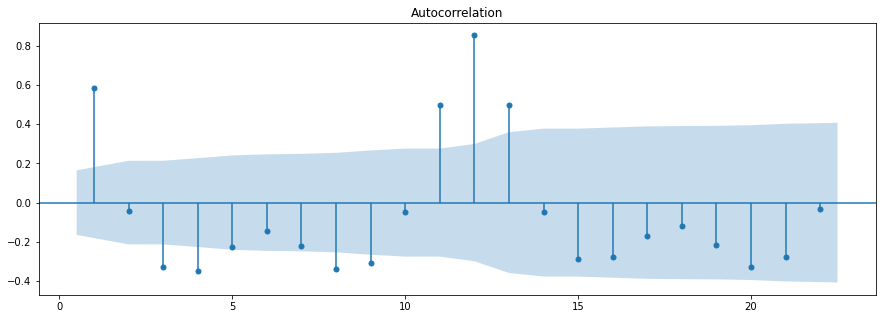

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(df, zero=False)

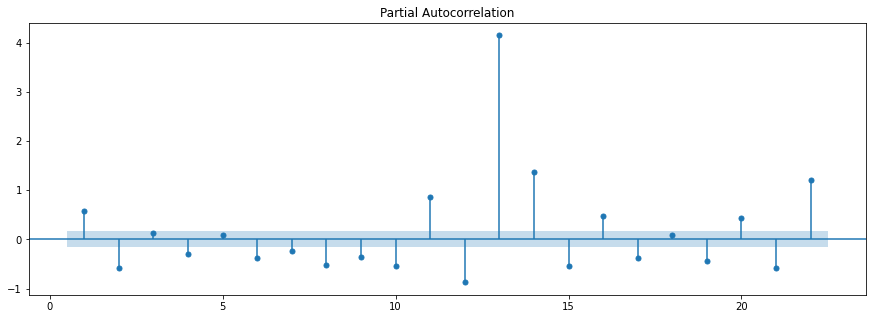

In [16]:
_ = plot_pacf(df, zero=False)

**Conclusion: ** in the AR model, the ACF plot has a gradual decreasing trend and the PACF plot cuts off after p significant lags. But the ACF plot above doesn't have a gradual decreasing trend. So, this process is not AR

## Choose model order and train

- **Split the data on training and test sets (test period = [1958-01-01, 1960-12-01])**

In [17]:
df_train, df_test = df["1949-03-01":"1957-12-31"], df["1958-01-01": "1960-12-01"]
df_train.shape, df_test.shape

((106, 1), (36, 1))

In [18]:
df_train.index.max(), df_test.index.min()

(Timestamp('1957-12-01 00:00:00'), Timestamp('1958-01-01 00:00:00'))

In [19]:
df_train.index.min(), df_test.index.max()

(Timestamp('1949-03-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

- **The statsmodel ARIMA class**

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
ar_model = ARIMA(df_train, order=(12, 0, 0))

C:\Users\Admin\anaconda3\envs\dsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\anaconda3\envs\dsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Admin\anaconda3\envs\dsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [22]:
fitted_ar_model = ar_model.fit()
print(fitted_ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  106
Model:                ARIMA(12, 0, 0)   Log Likelihood                -396.703
Date:                Fri, 30 Jul 2021   AIC                            821.407
Time:                        23:28:39   BIC                            858.695
Sample:                    03-01-1949   HQIC                           836.520
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1316      1.148      3.600      0.000       1.882       6.381
ar.L1          0.7099      0.109      6.528      0.000       0.497       0.923
ar.L2         -0.8379      0.113     -7.437      0.0

C:\Users\Admin\anaconda3\envs\dsp\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- **Plot the true observations and the fitted values of the model using the fitted model fittedvalues attribute**

In [23]:
fittedvalues = fitted_ar_model.fittedvalues

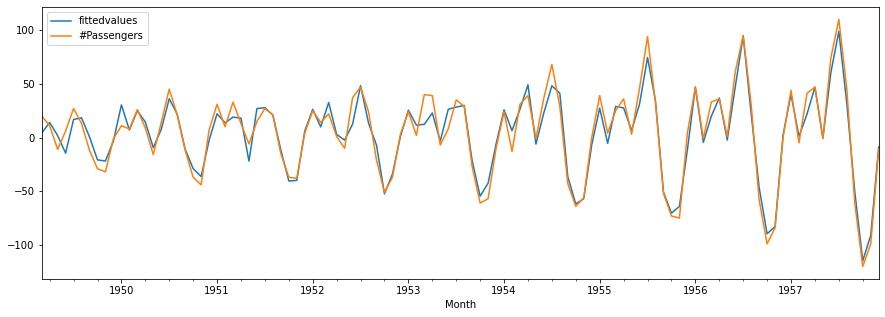

In [24]:
axis = fittedvalues.plot(label="fittedvalues", legend=True)
df_train.plot(ax=axis)
plt.show()

- **Compute and plot the residuals**

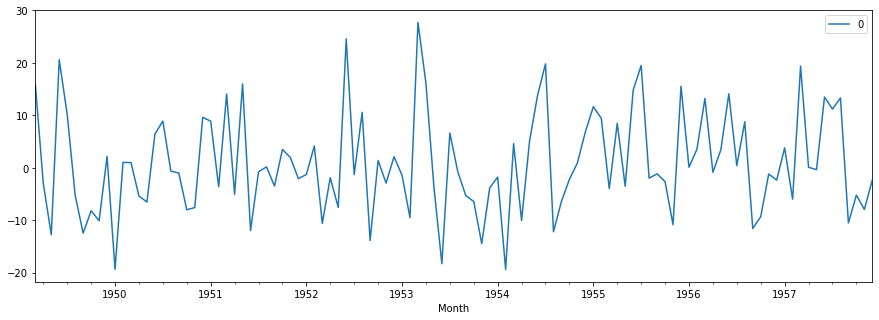

In [25]:
residuals = pd.DataFrame(fitted_ar_model.resid)
residuals.plot()
plt.show()

# Evaluation

## Forecast the test data

In [26]:
y_pred = fitted_ar_model.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

1958-01-01    37.894617
1958-02-01    -6.014084
1958-03-01    33.613471
1958-04-01    41.174523
1958-05-01     4.683780
Freq: MS, Name: predicted_mean, dtype: float64

## Compute MAPE score

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
mape_ar_score = mean_absolute_percentage_error(df_test, y_pred)
mape_ar_score

0.8668892861254228

## Plot the test data and the forecasts

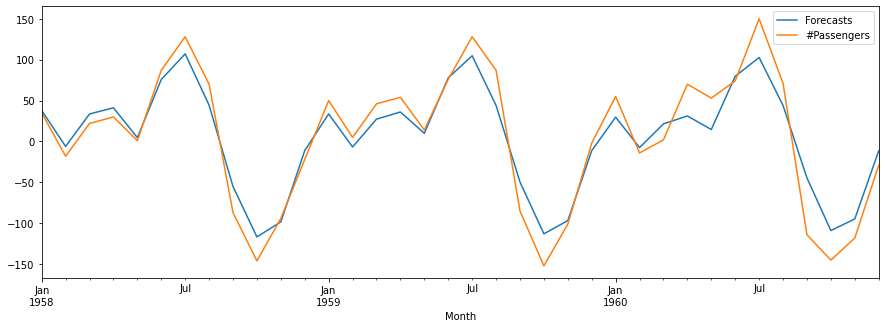

In [29]:
ax = y_pred.plot(label="Forecasts", legend=True)
df_test.plot(ax=ax)
plt.show()

## Expanding window cross validation

*The start date "1957-12-01" is in the index 105*

In [30]:
df[105:106]

,#Passengers
Month,
1957-12-01,-11.0


- **One step forecasting: window=1**

In [31]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
for idx in range(105, 142):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+1]
    
    # Train model
    model = ARIMA(trainset, order=(12, 0, 0))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.forecast()
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(idx-104))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")

Pass 1: 
Forecast: 1957-12-01   -8.227671
Freq: MS, dtype: float64
MAPE score: 0.2520299331982608
Pass 2: 
Forecast: 1958-01-01    37.894617
Freq: MS, dtype: float64
MAPE score: 0.08270334653639415
Pass 3: 
Forecast: 1958-02-01   -7.945293
Freq: MS, dtype: float64
MAPE score: 0.5585948139305774
Pass 4: 
Forecast: 1958-03-01    27.15191
Freq: MS, dtype: float64
MAPE score: 0.23417771278723312
Pass 5: 
Forecast: 1958-04-01    41.327897
Freq: MS, dtype: float64
MAPE score: 0.3775965814281283
Pass 6: 
Forecast: 1958-05-01    1.634052
Freq: MS, dtype: float64
MAPE score: 0.6340515008242926
Pass 7: 
Forecast: 1958-06-01    83.899753
Freq: MS, dtype: float64
MAPE score: 0.03563501770584604
Pass 8: 
Forecast: 1958-07-01    116.001913
Freq: MS, dtype: float64
MAPE score: 0.09373505422809325
Pass 9: 
Forecast: 1958-08-01    60.364867
Freq: MS, dtype: float64
MAPE score: 0.13764475660884118
Pass 10: 
Forecast: 1958-09-01   -43.739302
Freq: MS, dtype: float64
MAPE score: 0.49724940178246413
Pass 1

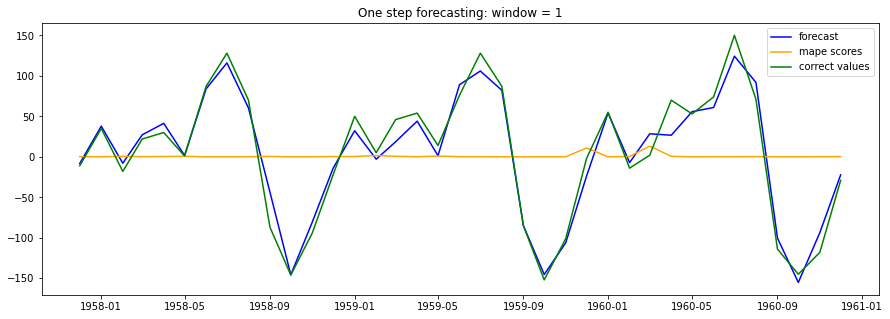

In [32]:
plt.plot(df[105:].index, forecasts, label="forecast", color='blue')
plt.plot(df[105:].index, mape_scores, label="mape scores", color='orange')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('One step forecasting: window = 1')
plt.legend()
plt.show()

- **Multi step forecasting: window=3**

In [33]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
pass_count = 1
for idx in range(105, 142, 3):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+3]
    
    # Train model
    model = ARIMA(trainset, order=(12, 0, 0))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.predict(start=testset.index[0], end=testset.index[-1])
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred.values)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(pass_count))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")
    pass_count += 1

Pass 1: 
Forecast: 1957-12-01    -8.227671
1958-01-01    39.845808
1958-02-01    -6.619788
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.34090520056017315
Pass 2: 
Forecast: 1958-03-01    27.151910
1958-04-01    44.077748
1958-05-01     6.610149
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 2.10452829307633
Pass 3: 
Forecast: 1958-06-01     83.899753
1958-07-01    111.882564
1958-08-01     48.372868
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.15683717392263927
Pass 4: 
Forecast: 1958-09-01    -43.739302
1958-10-01   -113.666396
1958-11-01    -95.078133
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.2433939785820243
Pass 5: 
Forecast: 1958-12-01   -13.960379
1959-01-01    37.778415
1959-02-01   -17.666074
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 1.7143612636634005
Pass 6: 
Forecast: 1959-03-01    18.587304
1959-04-01    25.446068
1959-05-01     5.843451
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score:

In [34]:
predictions = []
for i in forecasts:
    for j in i:
        predictions.append(j)

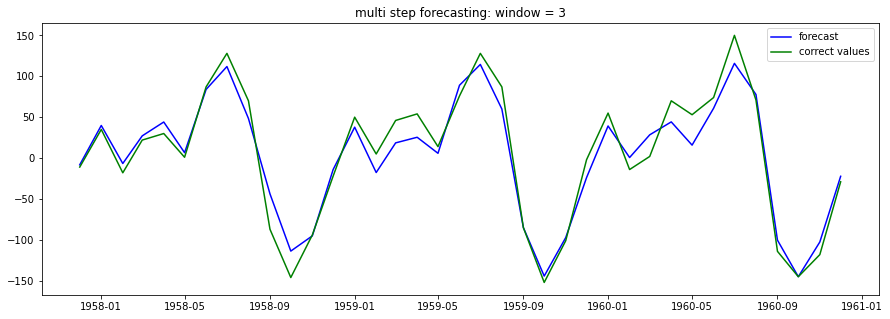

In [35]:
passes = [i for i in range(1, 14)]

plt.plot(df[105:].index, predictions, label="forecast", color='blue')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('multi step forecasting: window = 3')
plt.legend()
plt.show()

# Repeat the previous step for the MA and ARMA model

## MA Model

In [36]:
ma_model = ARIMA(df_train, order=(0, 0, 20))
fitted_ma_model = ma_model.fit()

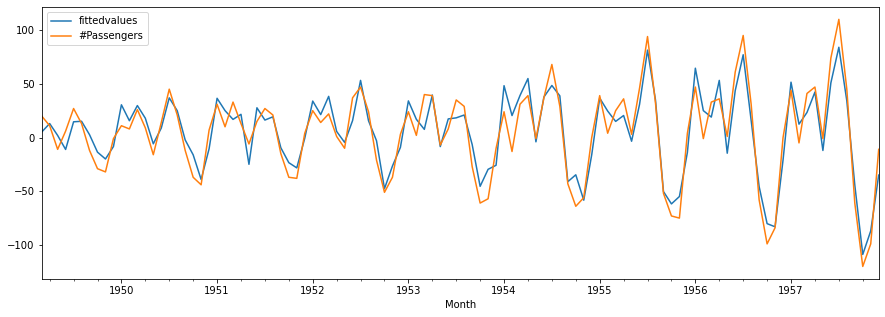

In [37]:
fittedvalues = fitted_ma_model.fittedvalues
axis = fittedvalues.plot(label="fittedvalues", legend=True)
df_train.plot(ax=axis)
plt.show()

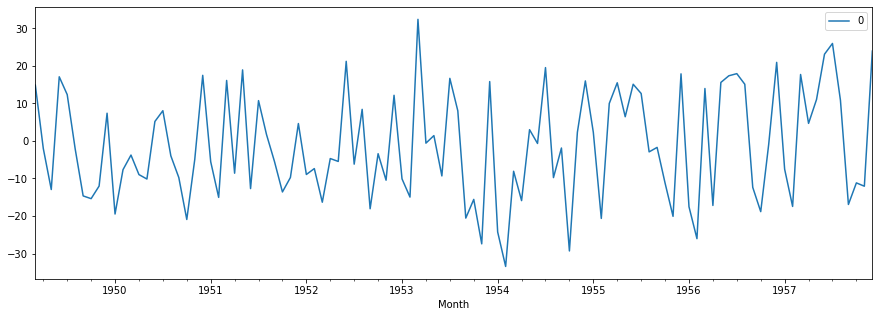

In [38]:
residuals = pd.DataFrame(fitted_ma_model.resid)
residuals.plot()
plt.show()

### **Forecast the test data**

In [39]:
y_pred = fitted_ma_model.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

1958-01-01    57.548387
1958-02-01    50.575016
1958-03-01    57.840260
1958-04-01    13.766654
1958-05-01   -34.838243
Freq: MS, Name: predicted_mean, dtype: float64

### **Compute MAPE score**

In [40]:
mape_ma_score = mean_absolute_percentage_error(df_test, y_pred)
mape_ma_score

2.2499224161851874

### **Plot the test data and the forecasts**

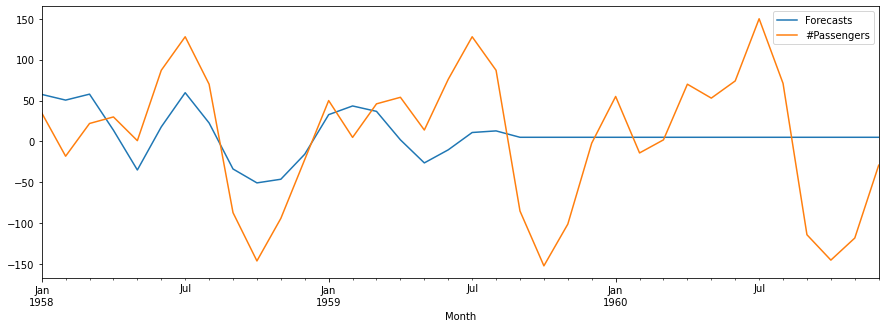

In [41]:
ax = y_pred.plot(label="Forecasts", legend=True)
df_test.plot(ax=ax)
plt.show()

### **Expanding window cross validation**

- **One step forecasting: window=1**

In [42]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
for idx in range(105, 142):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+1]
    
    # Train model
    model = ARIMA(trainset, order=(0, 0, 20))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.forecast()
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(idx-104))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")

Pass 1: 
Forecast: 1957-12-01   -23.576375
Freq: MS, dtype: float64
MAPE score: 1.1433067815771034
Pass 2: 
Forecast: 1958-01-01    57.548387
Freq: MS, dtype: float64
MAPE score: 0.6442396292667216
Pass 3: 
Forecast: 1958-02-01   -12.692767
Freq: MS, dtype: float64
MAPE score: 0.2948462610929753
Pass 4: 
Forecast: 1958-03-01    31.238896
Freq: MS, dtype: float64
MAPE score: 0.41994980964961637
Pass 5: 
Forecast: 1958-04-01    91.789728
Freq: MS, dtype: float64
MAPE score: 2.0596576045654897
Pass 6: 
Forecast: 1958-05-01   -15.043072
Freq: MS, dtype: float64
MAPE score: 16.04307223357751
Pass 7: 
Forecast: 1958-06-01    56.543528
Freq: MS, dtype: float64
MAPE score: 0.3500743851671133
Pass 8: 
Forecast: 1958-07-01    92.01152
Freq: MS, dtype: float64
MAPE score: 0.28115999643625345
Pass 9: 
Forecast: 1958-08-01    56.223286
Freq: MS, dtype: float64
MAPE score: 0.19681020435202987
Pass 10: 
Forecast: 1958-09-01   -39.402218
Freq: MS, dtype: float64
MAPE score: 0.5471009399141132
Pass 11:

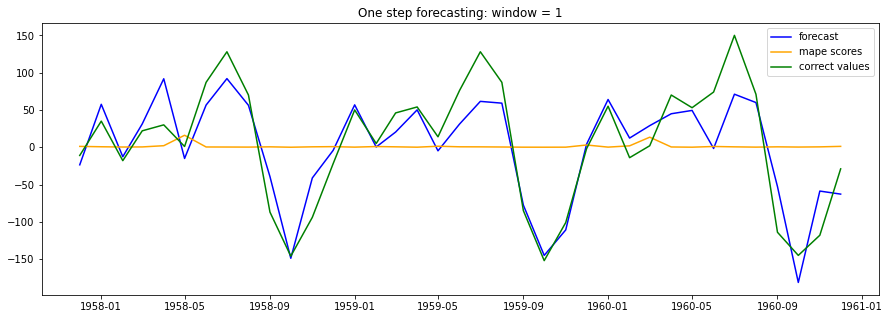

In [43]:
plt.plot(df[105:].index, forecasts, label="forecast", color='blue')
plt.plot(df[105:].index, mape_scores, label="mape scores", color='orange')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('One step forecasting: window = 1')
plt.legend()
plt.show()

- **Multi step forecasting: window=3**

In [44]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
pass_count = 1
for idx in range(105, 142, 3):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+3]
    
    # Train model
    model = ARIMA(trainset, order=(0, 0, 20))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.predict(start=testset.index[0], end=testset.index[-1])
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred.values)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(pass_count))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")
    pass_count += 1

Pass 1: 
Forecast: 1957-12-01   -23.576375
1958-01-01    12.034566
1958-02-01   -21.942204
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.6728244496069387
Pass 2: 
Forecast: 1958-03-01    31.238896
1958-04-01    94.725102
1958-05-01    69.752135
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 23.77652934381337
Pass 3: 
Forecast: 1958-06-01    56.543528
1958-07-01    82.614231
1958-08-01    48.932592
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.3352045569263143
Pass 4: 
Forecast: 1958-09-01   -39.402218
1958-10-01   -92.319489
1958-11-01   -84.883019
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.33725494580805476
Pass 5: 
Forecast: 1958-12-01    -4.201627
1959-01-01    81.064619
1959-02-01    31.402085
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 2.2369088181695713
Pass 6: 
Forecast: 1959-03-01    20.386969
1959-04-01    31.929802
1959-05-01     9.013057
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.440

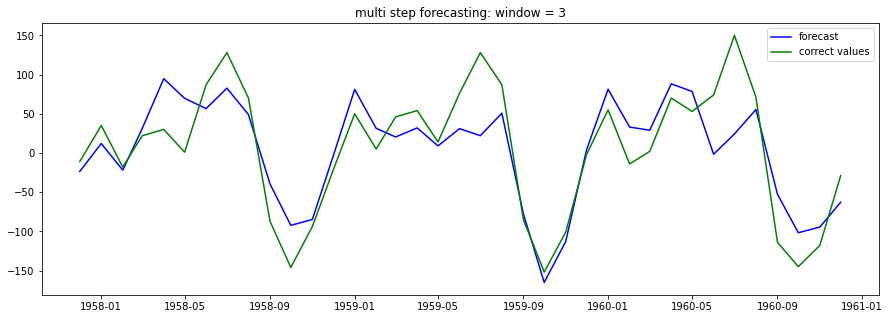

In [45]:
predictions = []
for i in forecasts:
    for j in i:
        predictions.append(j)
        
passes = [i for i in range(1, 14)]

plt.plot(df[105:].index, predictions, label="forecast", color='blue')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('multi step forecasting: window = 3')
plt.legend()
plt.show()

## ARMA model

In [46]:
arma_model = ARIMA(df_train, order=(12, 0, 20))
fitted_arma_model = arma_model.fit()

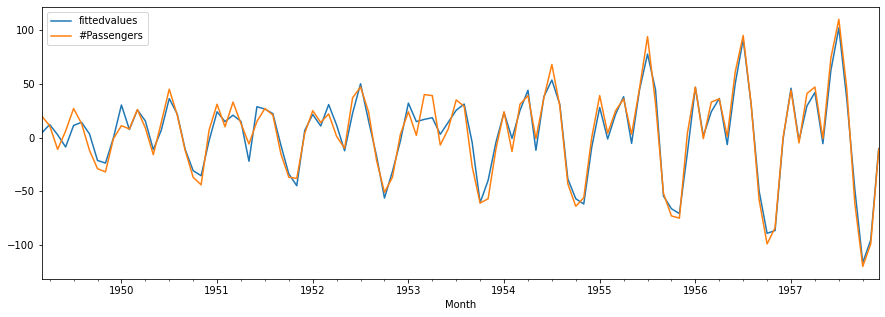

In [47]:
fittedvalues = fitted_arma_model.fittedvalues
axis = fittedvalues.plot(label="fittedvalues", legend=True)
df_train.plot(ax=axis)
plt.show()

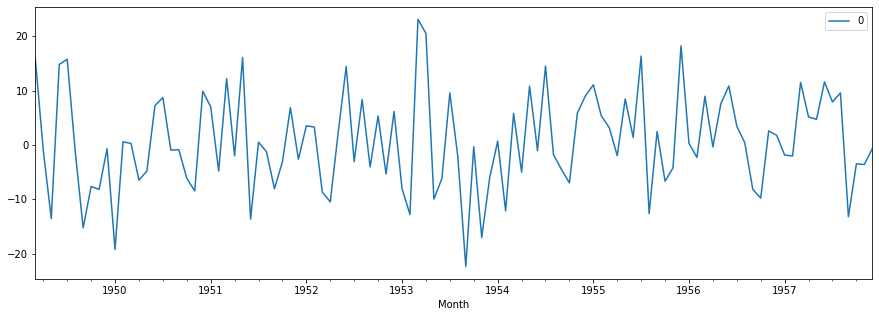

In [48]:
residuals = pd.DataFrame(fitted_arma_model.resid)
residuals.plot()
plt.show()

### Forecast the test data

In [49]:
y_pred = fitted_arma_model.predict(start=df_test.index[0], end=df_test.index[-1])
y_pred.head()

1958-01-01    37.713012
1958-02-01    -5.502342
1958-03-01    36.524270
1958-04-01    37.254161
1958-05-01    -2.547442
Freq: MS, Name: predicted_mean, dtype: float64

### Compute MAPE score

In [50]:
mape_arma_score = mean_absolute_percentage_error(df_test, y_pred)
mape_arma_score

1.123363489694719

### Plot the test data and the forecasts

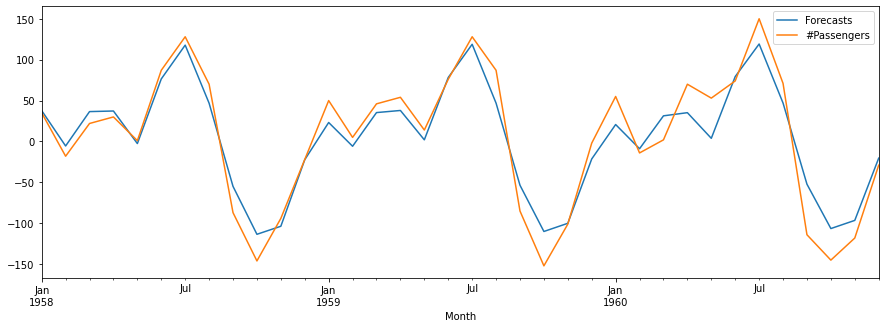

In [51]:
ax = y_pred.plot(label="Forecasts", legend=True)
df_test.plot(ax=ax)
plt.show()

### Expanding window cross validation

- **One step forecasting: window=1**

In [52]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
for idx in range(105, 142):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+1]
    
    # Train model
    model = ARIMA(trainset, order=(12, 0, 20))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.forecast()
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(idx-104))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")

Pass 1: 
Forecast: 1957-12-01   -6.712747
Freq: MS, dtype: float64
MAPE score: 0.389750283616957
Pass 2: 
Forecast: 1958-01-01    37.713012
Freq: MS, dtype: float64
MAPE score: 0.07751463368101018
Pass 3: 
Forecast: 1958-02-01   -8.772068
Freq: MS, dtype: float64
MAPE score: 0.5126629026833085
Pass 4: 
Forecast: 1958-03-01    28.649187
Freq: MS, dtype: float64
MAPE score: 0.30223575271475767
Pass 5: 
Forecast: 1958-04-01    37.997322
Freq: MS, dtype: float64
MAPE score: 0.2665773949062694
Pass 6: 
Forecast: 1958-05-01   -2.69918
Freq: MS, dtype: float64
MAPE score: 3.699180349471245
Pass 7: 
Forecast: 1958-06-01    92.183556
Freq: MS, dtype: float64
MAPE score: 0.05958109886638329
Pass 8: 
Forecast: 1958-07-01    112.267912
Freq: MS, dtype: float64
MAPE score: 0.12290693941541098
Pass 9: 
Forecast: 1958-08-01    57.234901
Freq: MS, dtype: float64
MAPE score: 0.18235855319245503
Pass 10: 
Forecast: 1958-09-01   -39.370257
Freq: MS, dtype: float64
MAPE score: 0.54746830882402
Pass 11: 
F

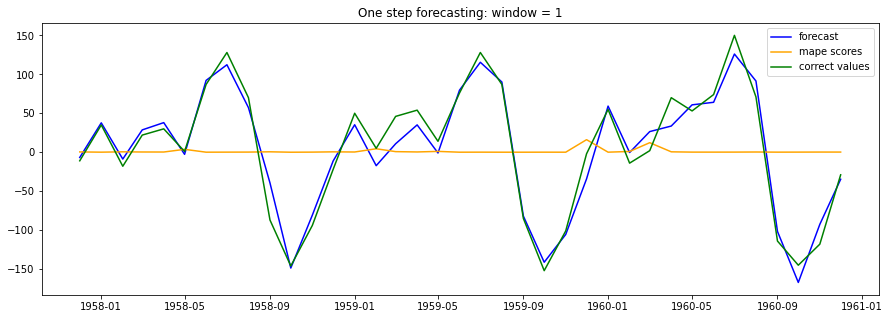

In [53]:
plt.plot(df[105:].index, forecasts, label="forecast", color='blue')
plt.plot(df[105:].index, mape_scores, label="mape scores", color='orange')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('One step forecasting: window = 1')
plt.legend()
plt.show()

- **Multi step forecasting: window=3**

In [54]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
mape_scores = []
pass_count = 1
for idx in range(105, 142, 3):
    # Select train and test set
    trainset, testset = df[0:idx], df[idx:idx+3]
    
    # Train model
    model = ARIMA(trainset, order=(12, 0, 20))
    fittedmodel = model.fit()
    
    # forecast and mape score
    pred = fittedmodel.predict(start=testset.index[0], end=testset.index[-1])
    mape_score = mean_absolute_percentage_error(testset, pred)
    
    # Save values
    forecasts.append(pred.values)
    mape_scores.append(mape_score)
    
    print("Pass {}: ".format(pass_count))
    print("Forecast: {}".format(pred))
    print("MAPE score: {}".format(mape_score))
    print("====================================")
    pass_count += 1

Pass 1: 
Forecast: 1957-12-01    -6.712747
1958-01-01    38.125763
1958-02-01   -11.323507
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.2833246916292392
Pass 2: 
Forecast: 1958-03-01    28.649187
1958-04-01    42.585768
1958-05-01     3.370945
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 1.0309020076767546
Pass 3: 
Forecast: 1958-06-01     92.183556
1958-07-01    118.585463
1958-08-01     44.733497
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.1646940724364094
Pass 4: 
Forecast: 1958-09-01    -39.370257
1958-10-01   -110.569392
1958-11-01    -98.023234
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 0.27764802165229124
Pass 5: 
Forecast: 1958-12-01   -11.222265
1959-01-01    36.058616
1959-02-01   -26.120645
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score: 2.330951210518329
Pass 6: 
Forecast: 1959-03-01    10.879910
1959-04-01    19.348455
1959-05-01     3.600859
Freq: MS, Name: predicted_mean, dtype: float64
MAPE score:

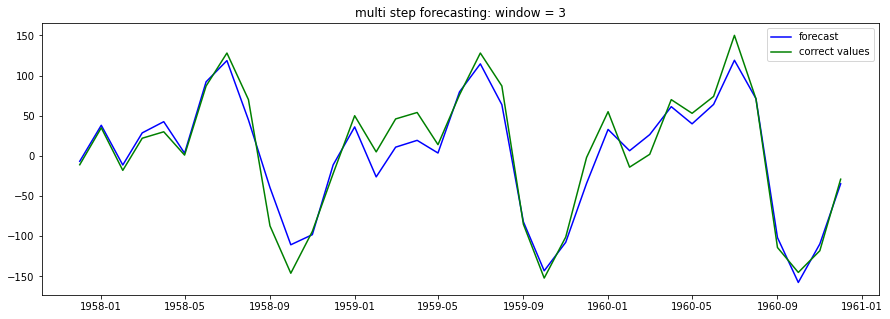

In [55]:
predictions = []
for i in forecasts:
    for j in i:
        predictions.append(j)
        
passes = [i for i in range(1, 14)]

plt.plot(df[105:].index, predictions, label="forecast", color='blue')
plt.plot(df[105:].index, df[105:], label="correct values", color='green')

plt.title('multi step forecasting: window = 3')
plt.legend()
plt.show()

# Benchmark the results

In [65]:
models = ['AR', 'MA', 'ARMA']
mape_scores = [mape_ar_score, mape_ma_score, mape_arma_score]
aic = [fitted_ar_model.aic, fitted_ma_model.aic, fitted_arma_model.aic]
bic = [fitted_ar_model.bic, fitted_ma_model.bic, fitted_arma_model.bic]

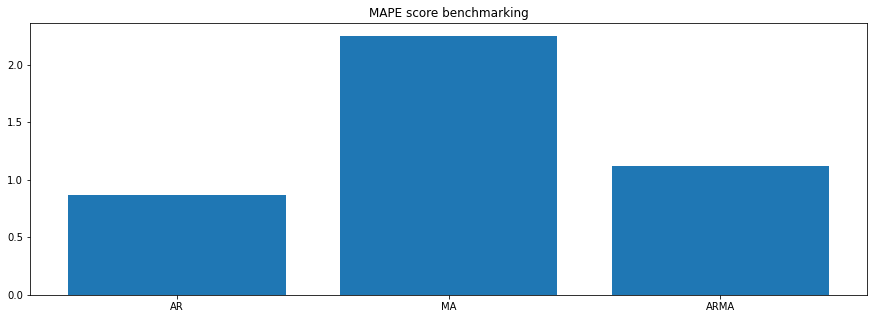

In [68]:
plt.bar(models, mape_scores)
plt.title("MAPE score benchmarking")
plt.show()

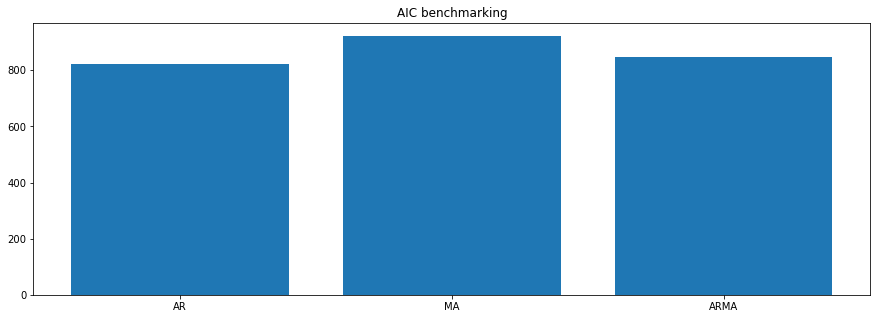

In [69]:
plt.bar(models, aic)
plt.title("AIC benchmarking")
plt.show()

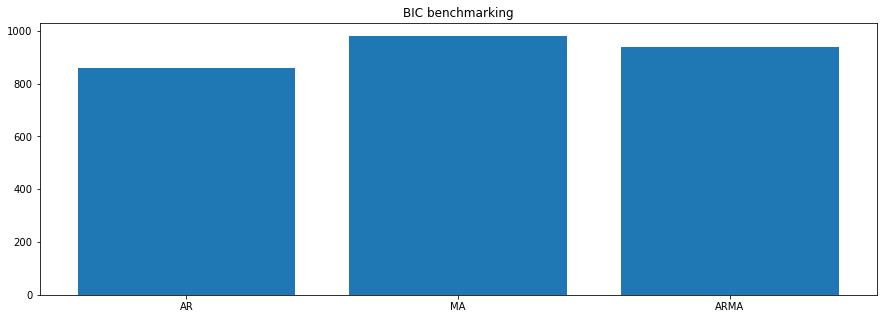

In [70]:
plt.bar(models, bic)
plt.title("BIC benchmarking")
plt.show()

# Forecast with the ARMA model

## Forecast using get_forecast method for a single step

In [75]:
prediction = fitted_arma_model.get_forecast(step=1)

In [88]:
prediction.tvalues

1958-01-01    4.839168
Freq: MS, Name: tvalues, dtype: float64

## Forecast using get_forecast method for multiple steps

In [107]:
predictions = fitted_arma_model.get_forecast(step=3)
predictions.tvalues

1958-01-01    4.839168
Freq: MS, Name: tvalues, dtype: float64

- *There is no different between two kind of steps*

## Original form

In [103]:
df_original = df_master.copy()
df_original.Month = pd.to_datetime(df_original.Month, format='%Y-%m')
df_original = df_original.set_index(DATE_COL)
df_original.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- **Train one step on original data form**

In [113]:
%%time
import warnings
warnings.filterwarnings('ignore')

forecasts   = []
for idx in range(105, 142):
    # Select train and test set
    trainset, testset = df_original[0:idx], df_original[idx:idx+1]
    
    # Train model
    model = ARIMA(trainset, order=(12, 0, 20))
    fittedmodel = model.fit()
    
    # get_forecast
    pred = fittedmodel.get_forecast(step=1).tvalues
    
    # Save values
    forecasts.append(pred)
    
    print("Pass {}: ".format(idx-104))
    print("Get Forecast: {}".format(pred))
    print("====================================")

Pass 1: 
Get Forecast: 1957-10-01    42.543703
Freq: MS, Name: tvalues, dtype: float64
Pass 2: 
Get Forecast: 1957-11-01    38.613878
Freq: MS, Name: tvalues, dtype: float64
Pass 3: 
Get Forecast: 1957-12-01    40.624177
Freq: MS, Name: tvalues, dtype: float64
Pass 4: 
Get Forecast: 1958-01-01    41.052403
Freq: MS, Name: tvalues, dtype: float64
Pass 5: 
Get Forecast: 1958-02-01    39.352926
Freq: MS, Name: tvalues, dtype: float64
Pass 6: 
Get Forecast: 1958-03-01    43.063679
Freq: MS, Name: tvalues, dtype: float64
Pass 7: 
Get Forecast: 1958-04-01    41.785295
Freq: MS, Name: tvalues, dtype: float64
Pass 8: 
Get Forecast: 1958-05-01    43.083387
Freq: MS, Name: tvalues, dtype: float64
Pass 9: 
Get Forecast: 1958-06-01    51.254538
Freq: MS, Name: tvalues, dtype: float64
Pass 10: 
Get Forecast: 1958-07-01    58.181479
Freq: MS, Name: tvalues, dtype: float64
Pass 11: 
Get Forecast: 1958-08-01    58.938299
Freq: MS, Name: tvalues, dtype: float64
Pass 12: 
Get Forecast: 1958-09-01    53.

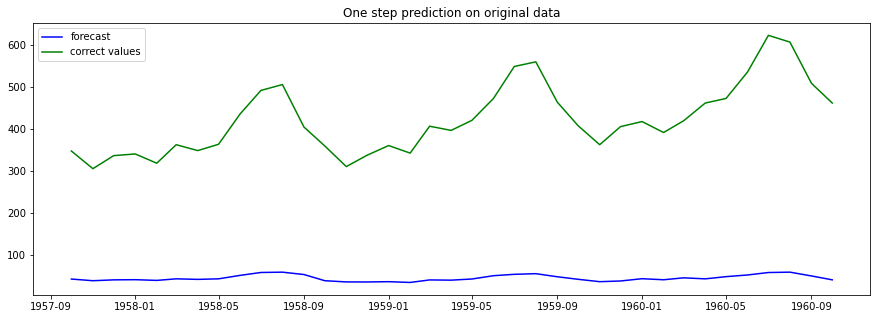

In [122]:
plt.plot(df_original[105:142].index, forecasts, label="forecast", color='blue')
plt.plot(df_original[105:142].index, df_original[105:142], label="correct values", color='green')

plt.title('One step prediction on original data')
plt.legend()
plt.show()

**When the data is not stationarity, the forecast is bad!**

## Bonus

:))